In [19]:
import json
import math
import re

from owlready2 import *
from utils.fsys import files
from collections import Counter

In [20]:
PATH = '/home/user/Source/repos/kuznetsovmd/ppr-dataset'
ANN = '/home/user/Source/repos/kuznetsovmd/ppr-annotations/012190650e118175fe2f538504434c7c.json'
DESC = f'{PATH}/json/plain.json'
POLS = f'{PATH}/output_policies'
FIGURE = 'resources/figures/structuredness.png'

In [21]:
def calculate_entropy(distribution):
    total = sum(distribution)
    if total == 0:
        return 0.0
    entropy = 0.0
    for count in distribution:
        if count > 0:
            p = count / total
            entropy -= p * math.log2(p)
    return entropy

In [22]:
def evaluate_onto_structuredness(ontology_path):
    # Загружаем онтологию
    onto = get_ontology(ontology_path).load()
    
    # Получаем все классы
    classes = list(onto.classes())
    if not classes:
        return 0.0

    # Считаем количество экземпляров в каждом классе
    instance_counts = []
    for cls in classes:
        instances = list(cls.instances())
        instance_counts.append(len(instances))

    # Энтропия H(O)
    H_O = calculate_entropy(instance_counts)

    # Максимальная энтропия Hmax(O) — при равномерном распределении экземпляров
    total_instances = sum(instance_counts)
    num_classes = len(classes)

    if num_classes == 0 or total_instances == 0:
        return 0.0

    uniform_distribution = [total_instances / num_classes] * num_classes
    H_max = calculate_entropy(uniform_distribution)

    # Структурированность
    structuredness = 1 - H_O / H_max if H_max > 0 else 0.0
    return structuredness

In [23]:
def evaluate_text_structuredness(text):
    words = re.findall(r'\b\w+\b', text.lower())
    
    if len(words) == 0:
        return 0.0
    
    word_counts = Counter(words)
    distribution = list(word_counts.values())

    H_T = calculate_entropy(distribution)
    H_max = math.log2(len(word_counts)) if len(word_counts) > 0 else 1

    structuredness = 1 - H_T / H_max if H_max > 0 else 0.0
    return structuredness

In [24]:
ontologies = files('resources/ontologies/annotated', r".*\.owl$")

In [25]:
with open(ANN, 'r') as f:
    hashes = set([a['policy_hash'] for a in json.load(f)])

with open(DESC, 'r') as f:
    policies = {p['policy_hash']: p['plain_policy'] for p in json.load(f) if p['policy_hash'] in hashes}

texts = []
for f in policies.values():
    with open(f'{POLS}/{f}', 'r') as s:
        texts.append(s.read())

In [26]:
ostr = [evaluate_onto_structuredness(o) for o in ontologies]
tstr = [evaluate_text_structuredness(t) for t in texts]

sum(data1) / len(data1) =0.3187390027088689, sum(data2) / len(data2) =0.09830282081468564


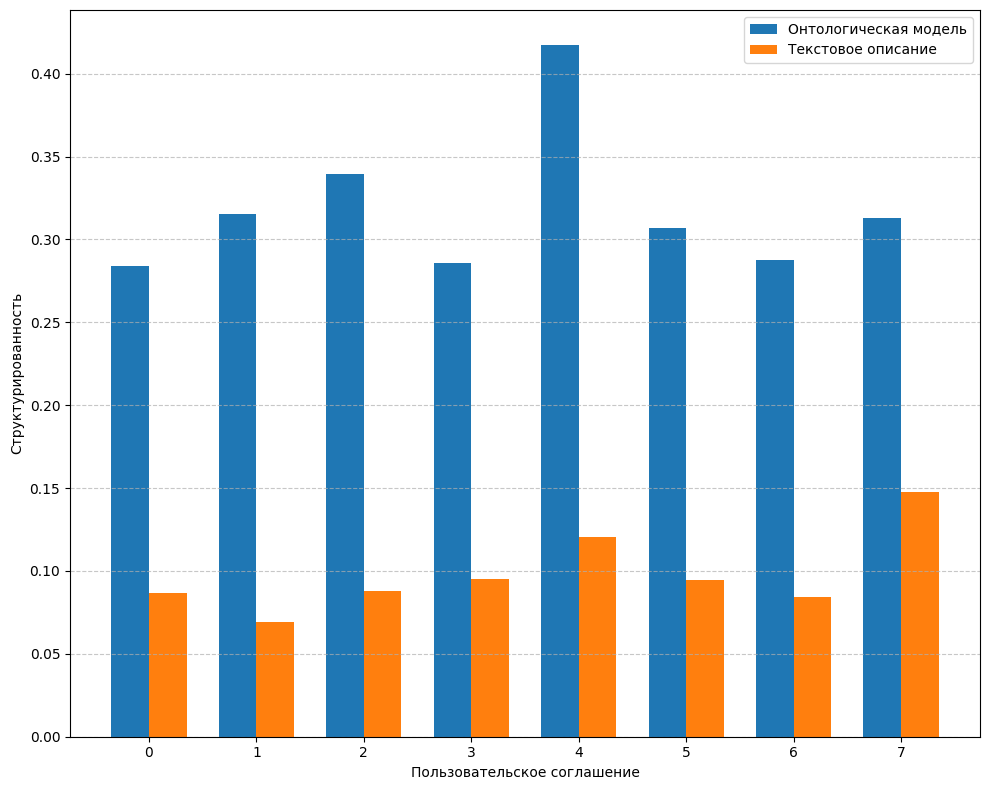

In [27]:
import matplotlib.pyplot as plt
import numpy as np

min_len = min(len(ostr), len(tstr))
data1 = ostr[:min_len]
data2 = tstr[:min_len]

print(f"{sum(data1) / len(data1) =}, {sum(data2) / len(data2) =}")

x = np.arange(min_len)

width = 0.35

plt.figure(figsize=(10, 8))
plt.bar(x - width/2, data1, width, label='Онтологическая модель')
plt.bar(x + width/2, data2, width, label='Текстовое описание')

plt.xlabel('Пользовательское соглашение')
plt.ylabel('Структурированность')
plt.legend()
plt.xticks(x)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(FIGURE, dpi=1000, bbox_inches='tight')
plt.show()